In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.067 s)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

try:
    plt.style.use("~/matplotlib.mplstyle")
except: raise

In [101]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return pd.DataFrame()
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

## Overlayed Histograms

In [6]:
gpteg = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'bandgap'
    AND method = 'GPT-3.5'
""")

gpttg = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'tg'
    AND method = 'GPT-3.5'
""")

mbteg = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'bandgap'
    AND method = 'MaterialsBERT'
""")

mbttg = execute("""
    SELECT * FROM extracted_data
    WHERE property = 'tg'
    AND method = 'MaterialsBERT'
""")


findfont: Font family ['Fira Math'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Fira Math'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Fira Math'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Fira Math'] not found. Falling back to DejaVu Sans.


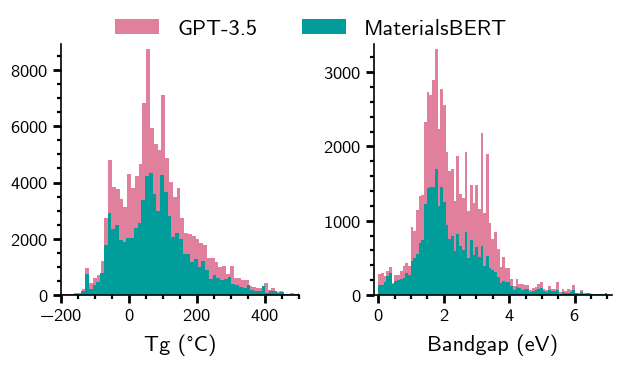

In [7]:
plt.rcParams['font.family'] = 'cursive'
n = 85

fig, ax = plt.subplots(1, 2, dpi=200, figsize=(3.25, 1.8))
ax[0].hist(gpttg.value, color='#e0809d', bins=n, label = 'GPT-3.5')
ax[0].hist(mbttg.value, color='#009d9a', bins=n, label = 'MaterialsBERT')
ax[0].set(xlabel='Tg (°C)', xlim=(-200, 500))

ax[1].hist(gpteg.value, color='#e0809d', bins=n, label = 'GPT-3.5')
ax[1].hist(mbteg.value, color='#009d9a', bins=n, label = 'MaterialsBERT')
ax[1].set(xlabel='Bandgap (eV)')

lines, labels = ax[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.06), bbox_transform=plt.gcf().transFigure, ncol=2)

plt.tight_layout()
plt.savefig('notebooks/Extracted-Data-Histograms.eps')
plt.show()

## Valid Data

In [14]:
df = execute("""
    SELECT ed.property, pm."name",
        sum(CASE WHEN ed."method" = 'GPT-3.5' 		THEN 1 ELSE 0 END) AS GPT,
        sum(CASE WHEN ed."method" = 'MaterialsBERT' THEN 1 ELSE 0 END) AS BERT
    FROM extracted_data ed 
    JOIN property_metadata pm ON pm.property = ed.property 
    GROUP BY ed.property, pm."name";
""")
df.to_csv('notebooks/property_data_list.csv', index=False)
df

,property,name,gpt,bert
0,bandgap,bandgap,63361,30732
1,co2_perm,CO_{2} permeability,2943,2561
2,cs,compressive strength,12343,6879
3,ct,crystallization temperature,12863,4045
4,eab,elongation at break,30754,15072
5,fs,flexural strength,7201,3543
6,h2_perm,H_{2} permeability,501,1072
7,hardness,hardness,5271,1984
8,iec,ion exchange capacity,3118,4656
9,is,impact strength,0,3607


In [12]:
df.sum()

property    bandgapco2_permcscteabfsh2_permhardnessiecislc...
gpt                                                    672449
bert                                                   394420
dtype: object

In [45]:
df = execute("""
    SELECT ed.material,
        sum(CASE WHEN ed."method" = 'GPT-3.5' 		THEN 1 ELSE 0 END) AS GPT,
        sum(CASE WHEN ed."method" = 'MaterialsBERT' THEN 1 ELSE 0 END) AS BERT,
        count(*) AS total
    FROM extracted_data ed 
    GROUP BY ed.material
    ORDER BY total DESC
    LIMIT 20;
""")

df.to_csv('notebooks/top_polymer_list.csv', index=False)
df

,material,gpt,bert,total
0,PLA,6491,7928,14419
1,PMMA,3407,4254,7661
2,PCL,3539,3996,7535
3,PP,2550,4820,7370
4,PVA,2408,4660,7068
5,PDMS,2140,4625,6765
6,PS,2144,4563,6707
7,PVDF,2252,4110,6362
8,PLLA,2775,2725,5500
9,PET,2187,2860,5047


In [46]:
df.sum()

material    PLAPMMAPCLPPPVAPDMSPSPVDFPLLAPETPNIPAMPEOP1PUp...
gpt                                                     41676
bert                                                    65017
total                                                  106693
dtype: object

## Venn Diagrams

In [36]:
def plot_venn_diagram(A, B, label_a, label_b, title="", saveas=None):
    A = set(A)
    B = set(B)
    a_not_b = len(A - B)
    b_not_a = len(B - A)
    a_and_b = len(A & B)
    total = a_not_b + b_not_a + a_and_b

    fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.8))
    v = venn2(subsets=(a_not_b, b_not_a, a_and_b), ax=ax)
    for p in v.patches:
        p.set_linewidth(1)
        p.set_edgecolor('k')

    v.get_label_by_id('10').set_text(f"{100 * a_not_b / total : 0.2f}%")
    v.get_label_by_id('01').set_text(f"{100 * b_not_a / total : 0.2f}%")
    v.get_label_by_id('11').set_text(f"{100 * a_and_b / total : 0.2f}%")
    title += f"\nTotal: {total :,}"
    print(title)
    # ax.set(title = title)
    plt.tight_layout()
    if saveas:
        plt.savefig(saveas, dpi=300)
    plt.show()

## Paragraphs

In [19]:
# Create a set of all paragraphs where GPT extracted data
gpt_paras = []

props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")

for prop in [p.property for p in props]:
    print(prop, end=' ')
    rows = postgres.raw_sql("""
    SELECT em.para_id as id
    FROM extracted_data ed 
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ed."method" = 'GPT-3.5' AND ed.property = :prop;
    """, prop=prop)
    for r in rows:
        gpt_paras.append(r.id)

print("\nDone. Total paras =", len(gpt_paras))

bandgap co2_perm cs ct eab fs h2_perm hardness iec is lcst loi meoh_perm o2_perm ri sd tc td tg tm ts ucst wca wu ym 
Done. Total paras = 672449


In [20]:
# Create a set of all paragraphs where MaterialsBERT extracted data
mtb_paras = []

props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")

for prop in [p.property for p in props]:
    print(prop, end=' ')
    rows = postgres.raw_sql("""
    SELECT em.para_id as id
    FROM extracted_data ed 
    JOIN extracted_properties ep ON ep.id = ed.property_id 
    JOIN extracted_materials em ON em.id = ep.material_id
    WHERE ed."method" = 'MaterialsBERT' AND ed.property = :prop;
    """, prop=prop)
    for r in rows:
        mtb_paras.append(r.id)

print("\nDone. Total paras =", len(mtb_paras))

bandgap co2_perm cs ct eab fs h2_perm hardness iec is lcst loi meoh_perm o2_perm ri sd tc td tg tm ts ucst wca wu ym 
Done. Total paras = 394420


Number of Paragraphs
Total: 338,680


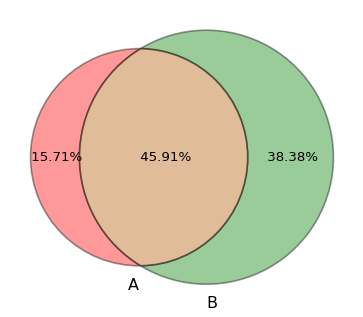

In [44]:
title="Number of Paragraphs"
saveas = "notebooks/venn_paragraphs.svg"

A = set(mtb_paras)
B = set(gpt_paras)

a_not_b = len(A - B)
b_not_a = len(B - A)
a_and_b = len(A & B)
total = a_not_b + b_not_a + a_and_b

fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.8))
v = venn2(subsets=(a_not_b, b_not_a, a_and_b), ax=ax)
for p in v.patches:
    p.set_linewidth(1)
    p.set_edgecolor('k')

# v.get_label_by_id('10').set_text(f"{a_not_b:,}")
# v.get_label_by_id('01').set_text(f"{b_not_a:,}")
# v.get_label_by_id('11').set_text(f"{a_and_b:,}")

v.get_label_by_id('10').set_text(f"{100 * a_not_b / total : 0.2f}%")
v.get_label_by_id('01').set_text(f"{100 * b_not_a / total : 0.2f}%")
v.get_label_by_id('11').set_text(f"{100 * a_and_b / total : 0.2f}%")


title += f"\nTotal: {total :,}"
print(title)

# ax.set(title = title)
plt.tight_layout()
if saveas:
    plt.savefig(saveas, dpi=300)
plt.show()

## Materials

In [14]:
# Create a set of all paragraphs where GPT extracted data
gpt_mats = []

props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")

for prop in [p.property for p in props]:
    print(prop, end=' ')
    rows = postgres.raw_sql("""
    SELECT ed.material
    FROM extracted_data ed 
    WHERE ed."method" = 'GPT-3.5' AND ed.property = :prop;
    """, prop=prop)
    for r in rows:
        gpt_mats.append(r.material)

print("\nDone. Total materials =", len(gpt_mats))

bandgap co2_perm cs ct eab fs h2_perm hardness iec is lcst loi meoh_perm o2_perm ri sd tc td tg tm ts ucst wca wu ym 
Done. Total materials = 672449


In [16]:
# Create a set of all paragraphs where MaterialsBERT extracted data
mtb_mats = []

props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")

for prop in [p.property for p in props]:
    print(prop, end=' ')
    rows = postgres.raw_sql("""
    SELECT ed.material
    FROM extracted_data ed 
    WHERE ed."method" = 'MaterialsBERT' AND ed.property = :prop;
    """, prop=prop)
    for r in rows:
        mtb_mats.append(r.material)

print("\nDone. Total materials =", len(mtb_mats))

bandgap co2_perm cs ct eab fs h2_perm hardness iec is lcst loi meoh_perm o2_perm ri sd tc td tg tm ts ucst wca wu ym 
Done. Total materials = 394420


Number of Materials
Total: 354,935


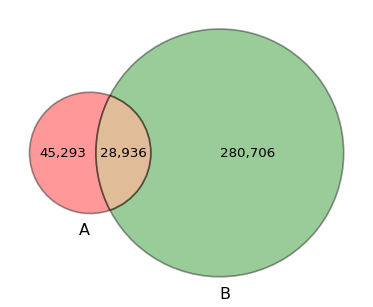

In [42]:
title="Number of Materials"
saveas = "notebooks/venn_materials.svg"

A = set(mtb_mats)
B = set(gpt_mats)

a_not_b = len(A - B)
b_not_a = len(B - A)
a_and_b = len(A & B)
total = a_not_b + b_not_a + a_and_b

fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.8))
v = venn2(subsets=(a_not_b, b_not_a, a_and_b), ax=ax)
for p in v.patches:
    p.set_linewidth(1)
    p.set_edgecolor('k')

v.get_label_by_id('10').set_text(f"{a_not_b:,}")
v.get_label_by_id('01').set_text(f"{b_not_a:,}")
v.get_label_by_id('11').set_text(f"{a_and_b:,}")

v.get_label_by_id('10').set_text(f"{100 * a_not_b / total : 0.2f}%")
v.get_label_by_id('01').set_text(f"{100 * b_not_a / total : 0.2f}%")
v.get_label_by_id('11').set_text(f"{100 * a_and_b / total : 0.2f}%")

title += f"\nTotal: {total :,}"
print(title)

# ax.set(title = title)
plt.tight_layout()
if saveas:
    plt.savefig(saveas, dpi=300)
plt.show()

## Pairwise Plots

In [112]:
def plot_jitter_pair(material, prop1, prop2, n = 100):
    gpt1 = execute("""
        SELECT material, property, value FROM extracted_data ed 
        WHERE ed.material   = :mat
        AND ed."method"     = :method
        AND ed.property     = :prop;
    """, mat = material, method = 'GPT-3.5', prop = prop1)
    
    gpt2 = execute("""
        SELECT material, property, value FROM extracted_data ed 
        WHERE ed.material   = :mat
        AND ed."method"     = :method
        AND ed.property     = :prop;
    """, mat = material, method = 'GPT-3.5', prop = prop2)

    mbt1 = execute("""
        SELECT material, property, value FROM extracted_data ed 
        WHERE ed.material   = :mat
        AND ed."method"     = :method
        AND ed.property     = :prop;
    """, mat = material, method = 'MaterialsBERT', prop = prop1)
    
    mbt2 = execute("""
        SELECT material, property, value FROM extracted_data ed 
        WHERE ed.material   = :mat
        AND ed."method"     = :method
        AND ed.property     = :prop;
    """, mat = material, method = 'MaterialsBERT', prop = prop2)

    m1 = min(mbt1.shape[0], mbt2.shape[0])
    m2 = min(gpt1.shape[0], gpt2.shape[0])

    fig, ax = plt.subplots(1, 1, figsize=(4.25, 2.0))

    if m1 > 0:
        ax.plot(
            [mbt1.sample().value.iloc[0] for _ in range(n)],
            [mbt2.sample().value.iloc[0] for _ in range(n)],
            'x', color="#009d9a", label = 'MaterialsBERT')

    if m2 > 0:
        ax.plot(
            [gpt1.sample().value.iloc[0] for _ in range(n)],
            [gpt2.sample().value.iloc[0] for _ in range(n)],
            '.', color="#e0809d", label = 'GPT-3.5')

    ax.set(xlabel=prop1, ylabel=prop2, title=material)
    ax.legend(loc=(1.01, 0.4))
    plt.tight_layout()
    plt.show()

In [130]:
def plot_pairwise(prop1, prop2):
    gpt = execute("""
        SELECT * FROM (
            SELECT ed.material,
                avg(CASE WHEN ed.property = :p1 THEN ed.value END) AS prop1,
                avg(CASE WHEN ed.property = :p2 THEN ed.value END) AS prop2
            FROM extracted_data ed 
            WHERE ed."method" = 'GPT-3.5'
            GROUP BY ed.material
            ORDER BY ed.material
        ) AS ft
        WHERE ft.prop1 IS NOT NULL AND ft.prop2 IS NOT NULL;
    """, p1=prop1, p2=prop2)

    mbt = execute("""
        SELECT * FROM (
            SELECT ed.material,
                avg(CASE WHEN ed.property = :p1 THEN ed.value END) AS prop1,
                avg(CASE WHEN ed.property = :p2 THEN ed.value END) AS prop2
            FROM extracted_data ed 
            WHERE ed."method" = 'MaterialsBERT'
            GROUP BY ed.material
            ORDER BY ed.material
        ) AS ft
        WHERE ft.prop1 IS NOT NULL AND ft.prop2 IS NOT NULL;
    """, p1=prop1, p2=prop2)

    fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.5))
    ax.plot(gpt.prop1, gpt.prop2, '.', color="#e0809dcc", label = 'GPT-3.5')
    ax.plot(mbt.prop1, mbt.prop2, '.', color="#009d9acc", label = 'MaterialsBERT')
    ax.set(xlabel=prop1, ylabel=prop2)
    ax.legend(ncol=2, loc=(0.1, 1.02))
    plt.tight_layout()
    plt.show()

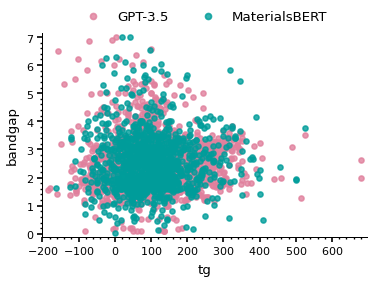

In [131]:
plot_pairwise('tg', 'bandgap')

co2_perm vs. bandgap


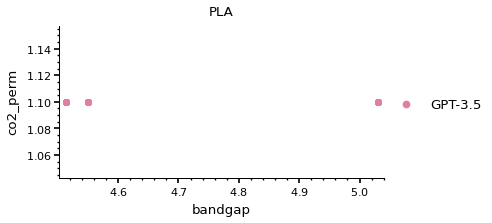

cs vs. bandgap


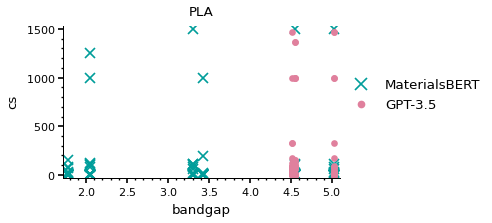

ct vs. bandgap


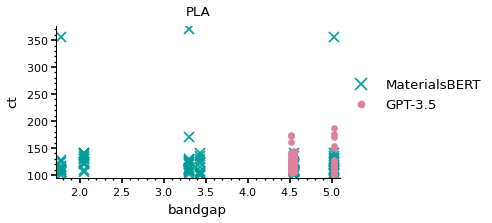

eab vs. bandgap


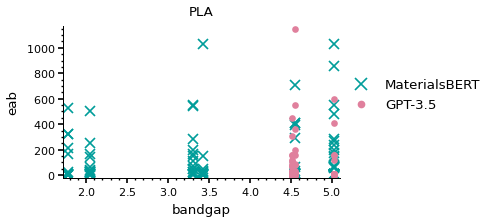

fs vs. bandgap


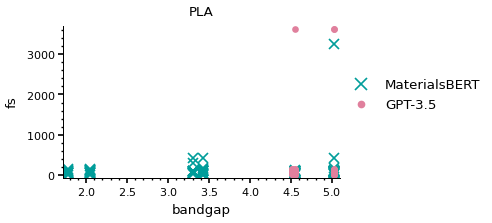

h2_perm vs. bandgap


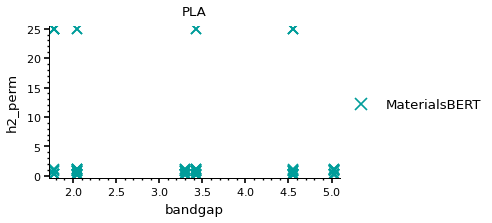

hardness vs. bandgap


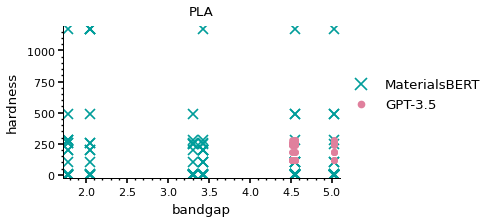

iec vs. bandgap


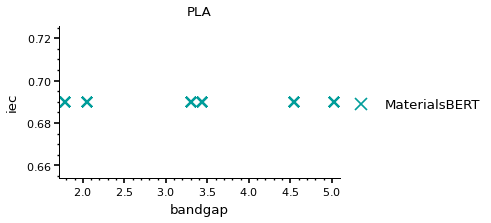

is vs. bandgap


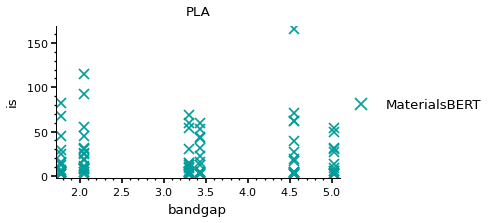

lcst vs. bandgap


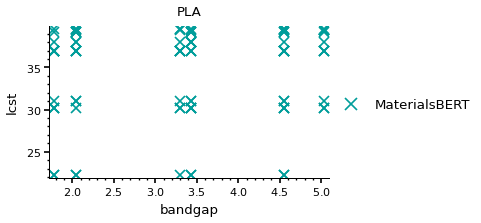

loi vs. bandgap


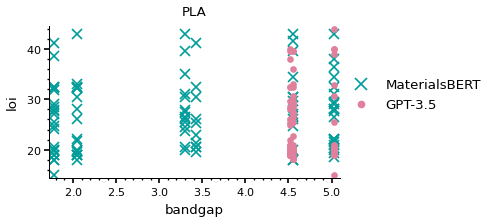

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meoh_perm vs. bandgap


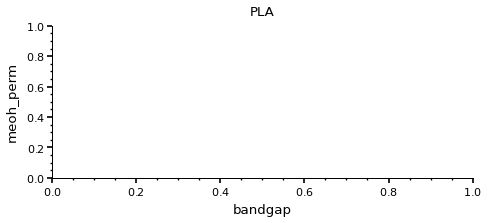

o2_perm vs. bandgap


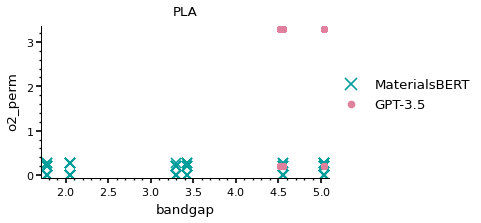

ri vs. bandgap


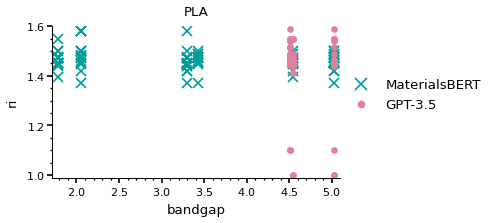

sd vs. bandgap


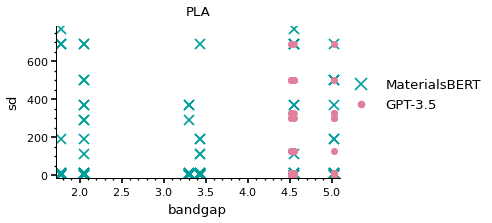

tc vs. bandgap


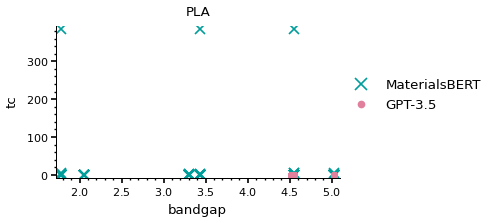

td vs. bandgap


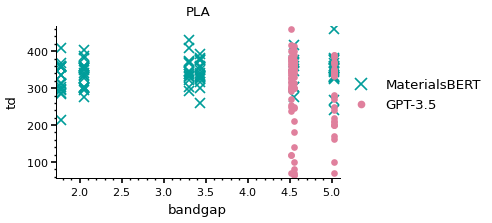

tg vs. bandgap


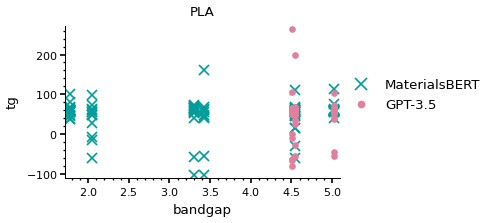

tm vs. bandgap


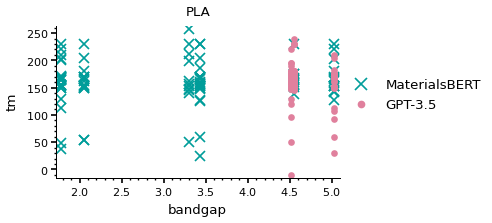

ts vs. bandgap


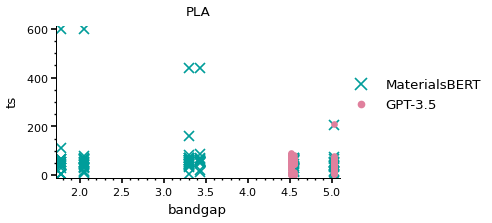

ucst vs. bandgap


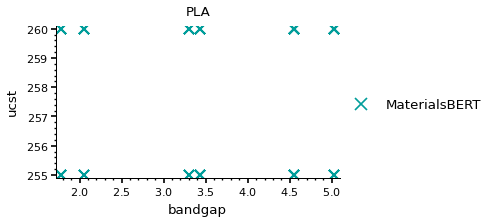

wca vs. bandgap


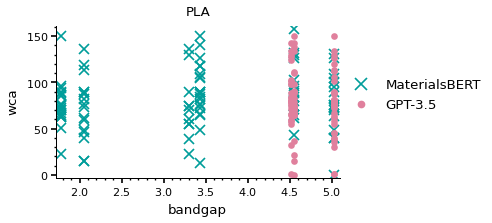

wu vs. bandgap


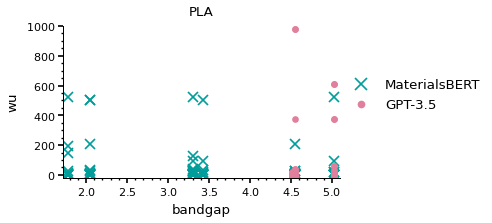

ym vs. bandgap


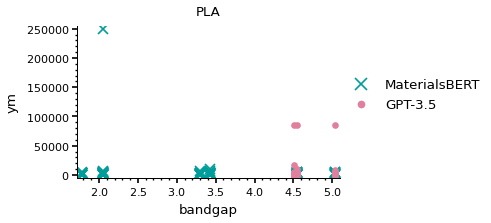

bandgap vs. co2_perm


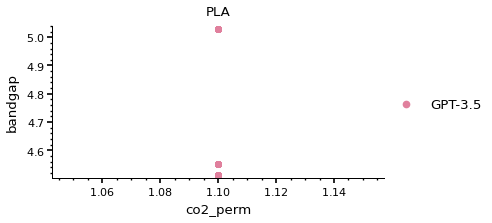

cs vs. co2_perm


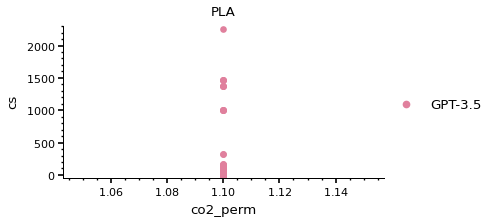

ct vs. co2_perm


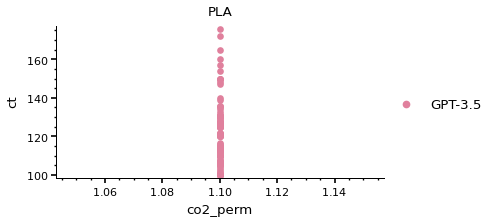

eab vs. co2_perm


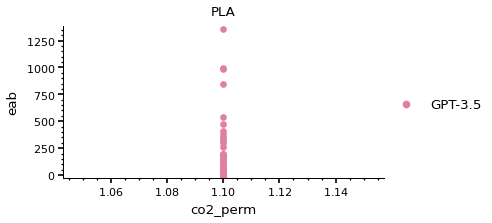

fs vs. co2_perm


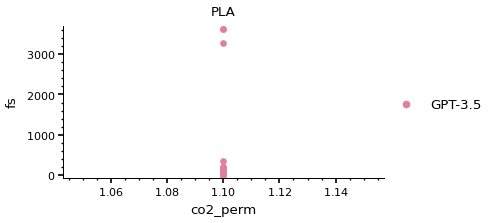

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


h2_perm vs. co2_perm


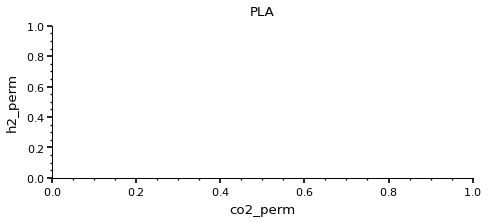

hardness vs. co2_perm


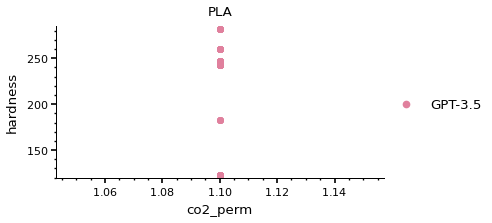

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


iec vs. co2_perm


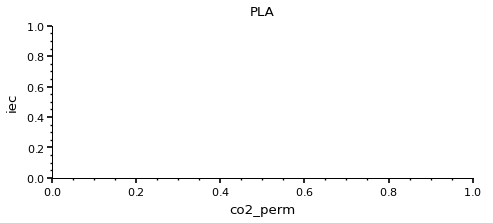

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


is vs. co2_perm


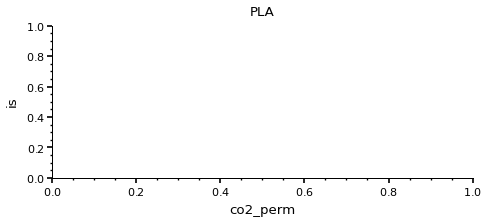

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


lcst vs. co2_perm


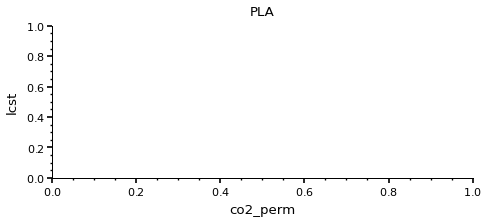

loi vs. co2_perm


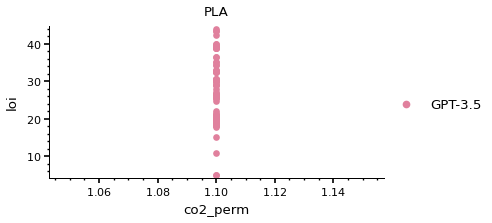

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meoh_perm vs. co2_perm


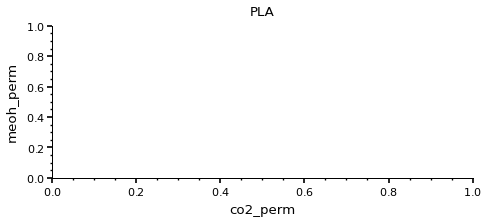

o2_perm vs. co2_perm


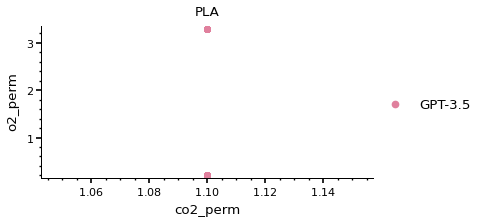

ri vs. co2_perm


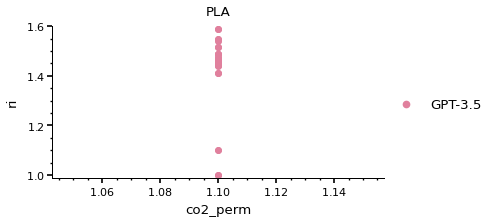

sd vs. co2_perm


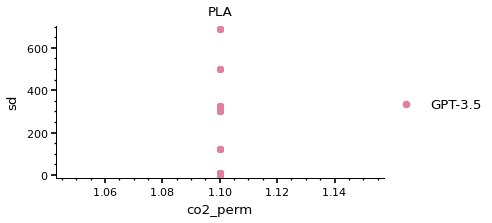

tc vs. co2_perm


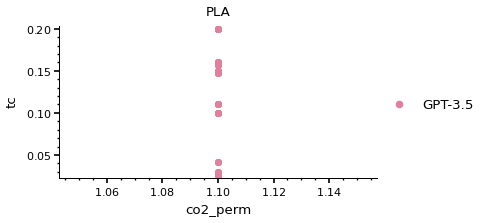

td vs. co2_perm


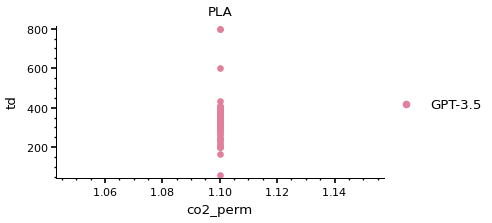

tg vs. co2_perm


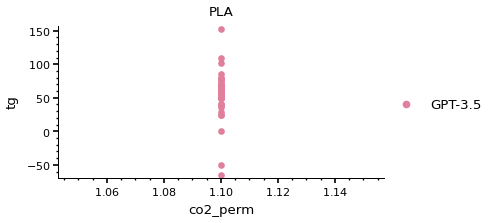

tm vs. co2_perm


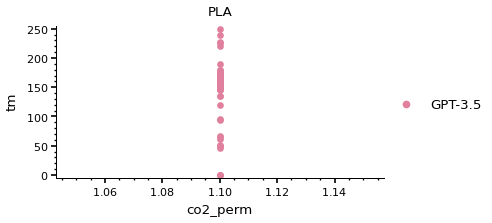

ts vs. co2_perm


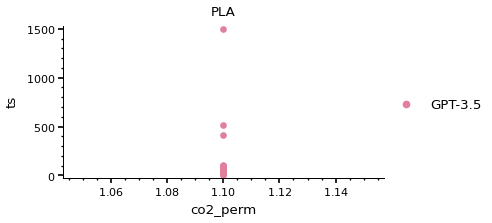

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ucst vs. co2_perm


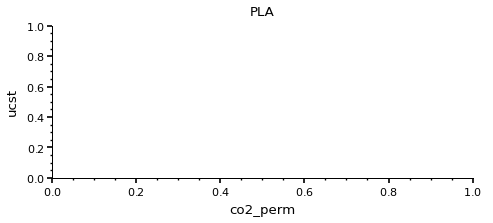

wca vs. co2_perm


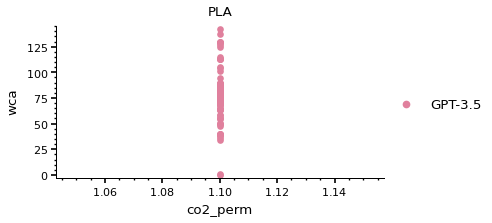

wu vs. co2_perm


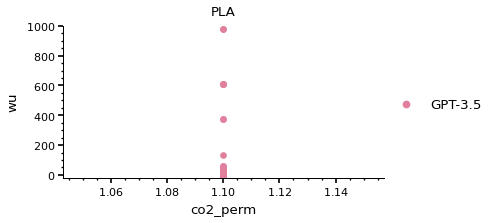

ym vs. co2_perm


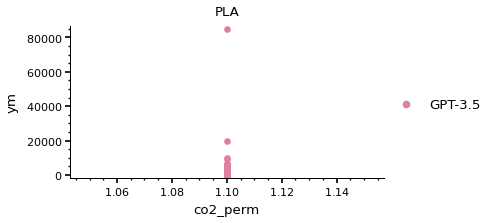

bandgap vs. cs


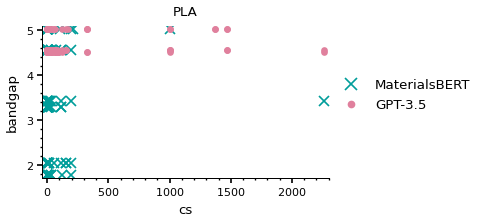

co2_perm vs. cs


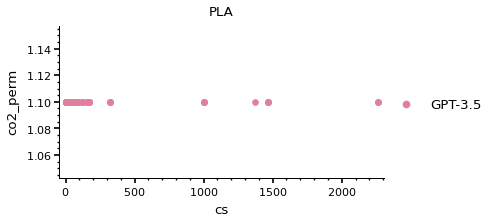

ct vs. cs


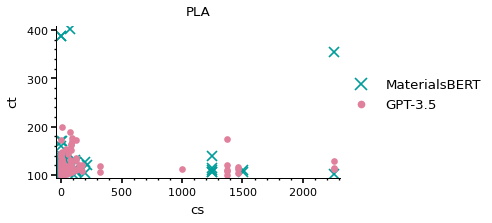

eab vs. cs


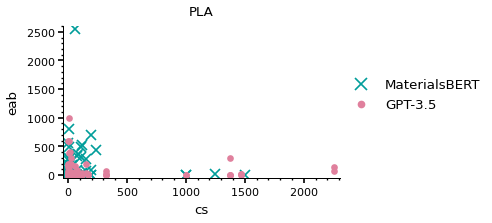

fs vs. cs


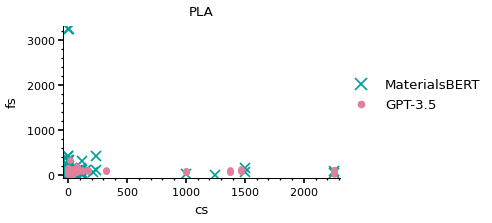

h2_perm vs. cs


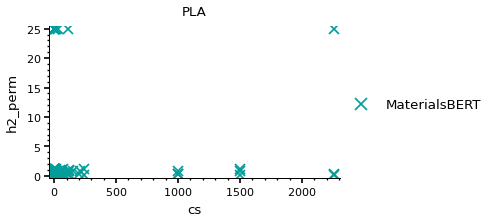

hardness vs. cs


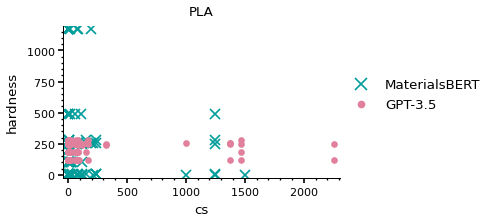

iec vs. cs


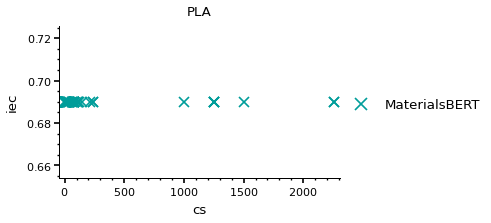

is vs. cs


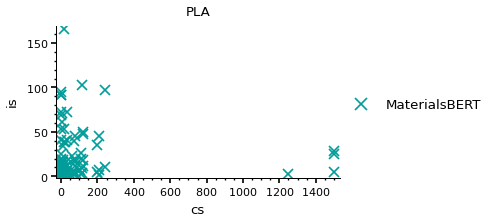

lcst vs. cs


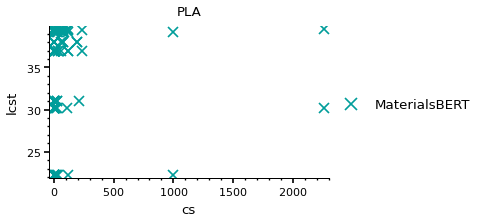

loi vs. cs


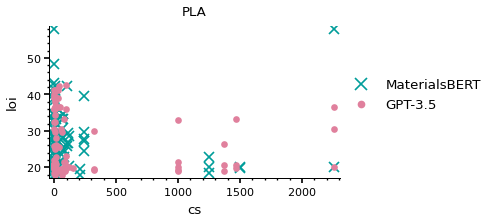

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meoh_perm vs. cs


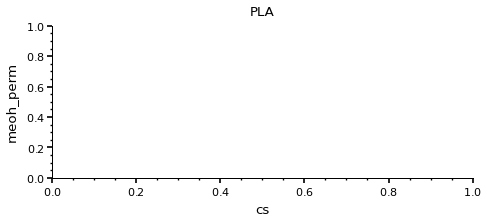

o2_perm vs. cs


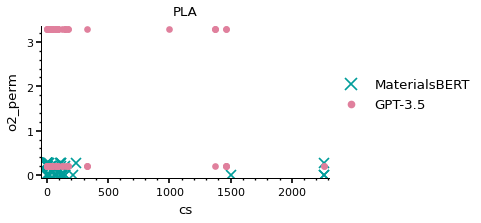

ri vs. cs


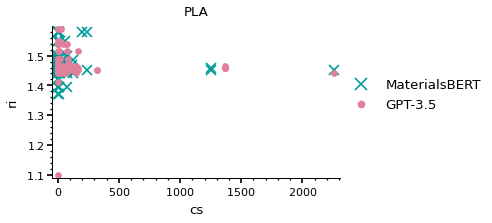

sd vs. cs


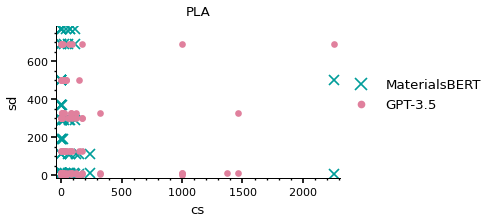

tc vs. cs


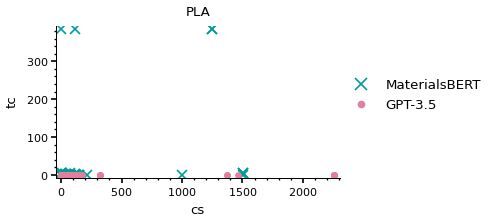

td vs. cs


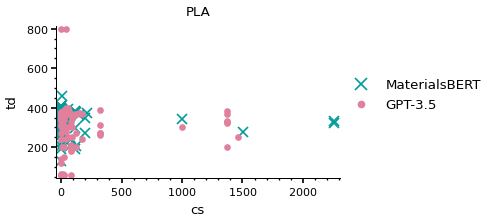

tg vs. cs


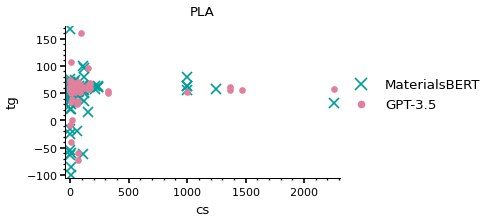

tm vs. cs


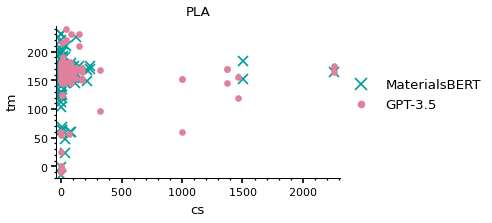

ts vs. cs


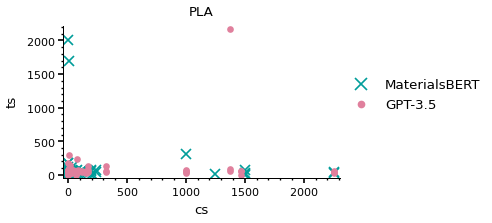

ucst vs. cs


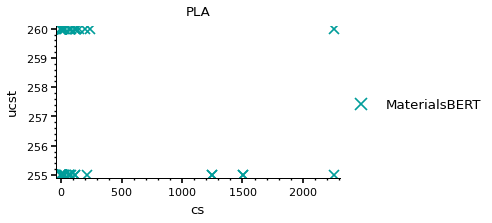

wca vs. cs


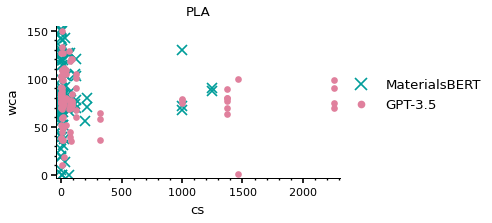

wu vs. cs


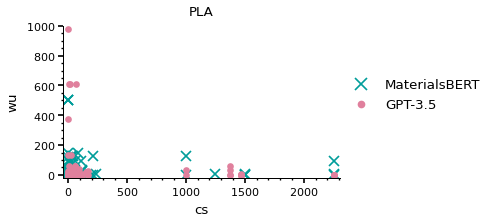

ym vs. cs


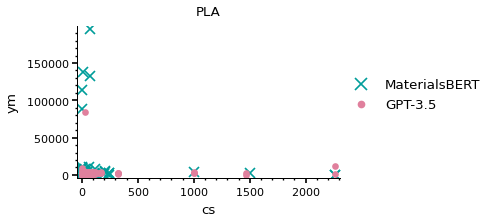

bandgap vs. ct


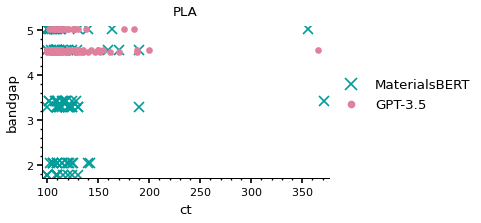

co2_perm vs. ct


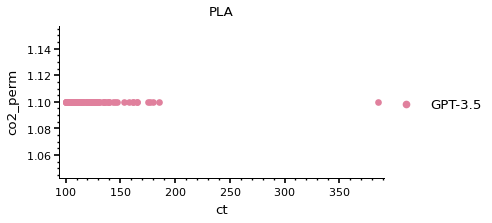

cs vs. ct


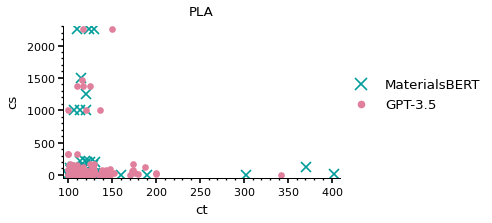

eab vs. ct


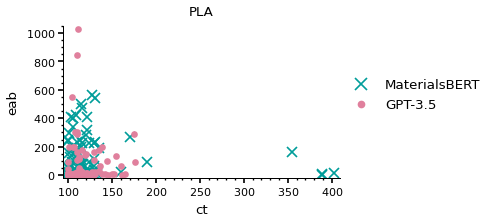

fs vs. ct


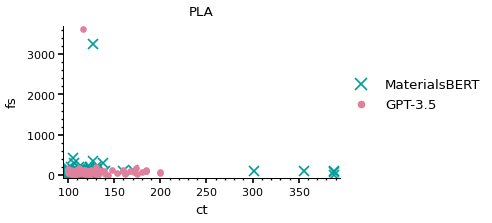

h2_perm vs. ct


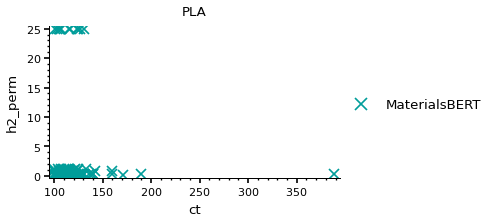

hardness vs. ct


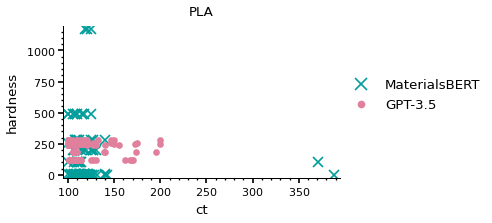

iec vs. ct


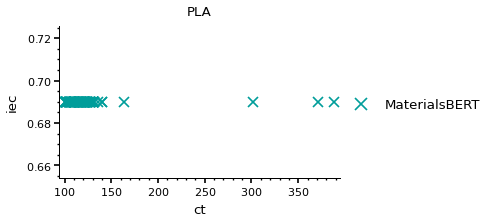

is vs. ct


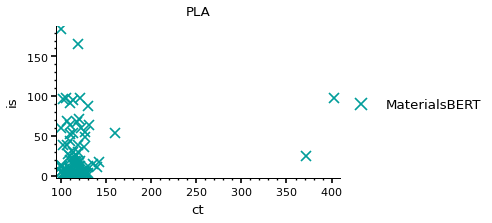

lcst vs. ct


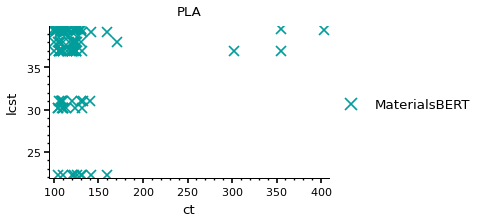

loi vs. ct


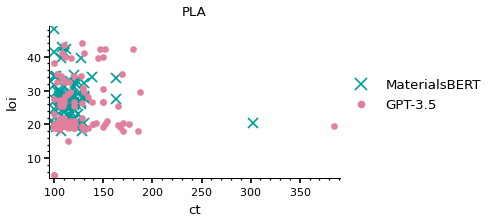

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meoh_perm vs. ct


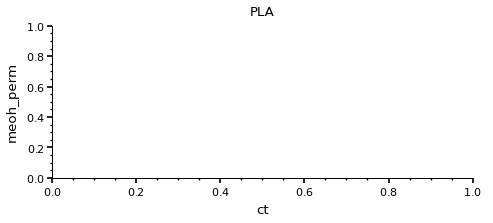

o2_perm vs. ct


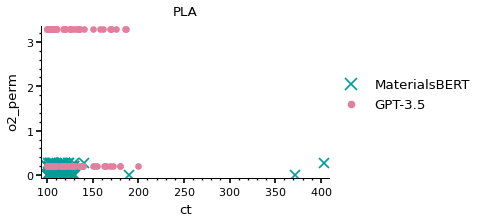

ri vs. ct


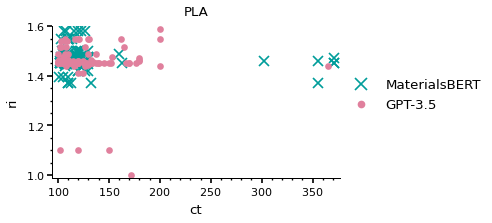

sd vs. ct


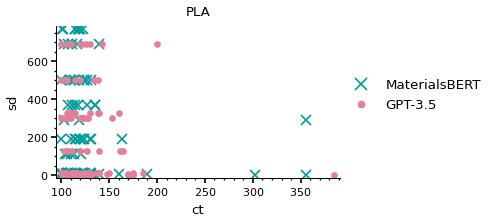

tc vs. ct


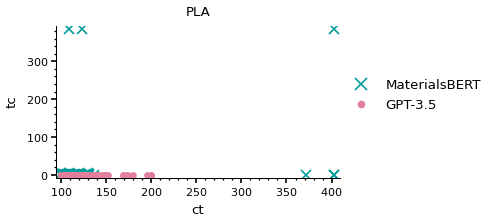

td vs. ct


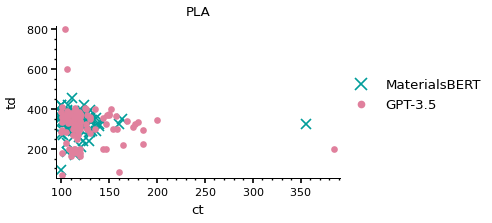

tg vs. ct


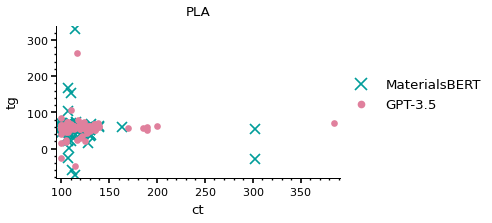

tm vs. ct


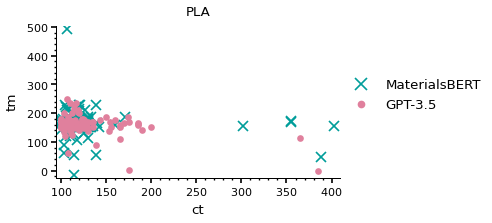

ts vs. ct


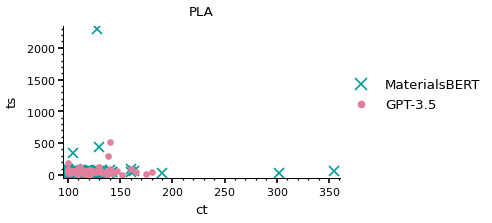

ucst vs. ct


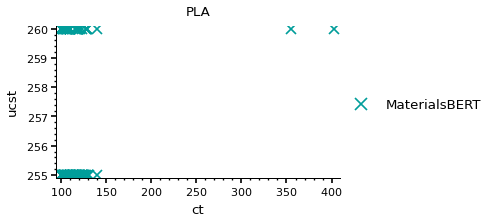

wca vs. ct


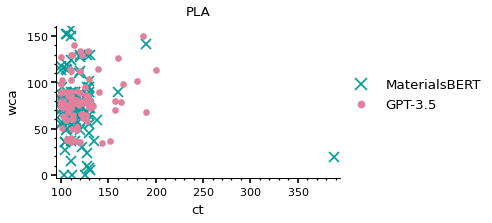

wu vs. ct


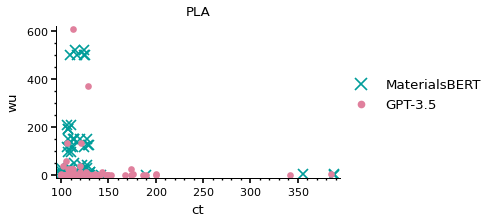

ym vs. ct


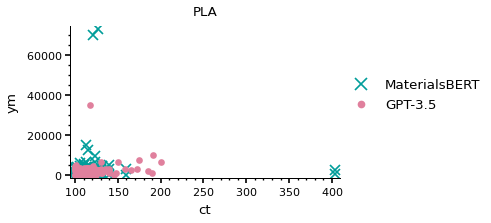

bandgap vs. eab


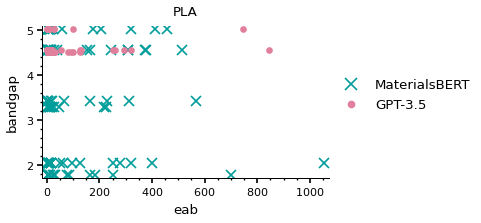

co2_perm vs. eab


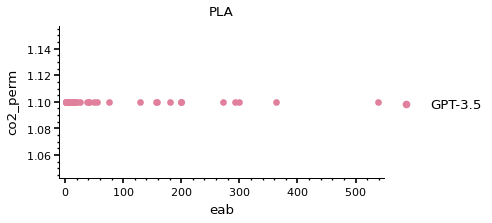

cs vs. eab


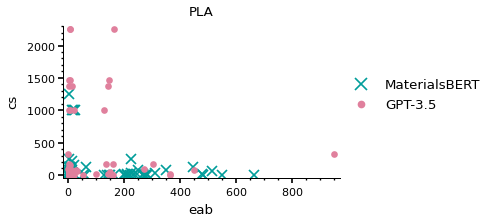

ct vs. eab


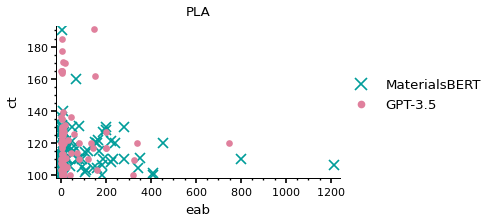

fs vs. eab


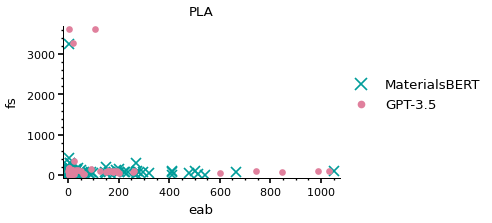

h2_perm vs. eab


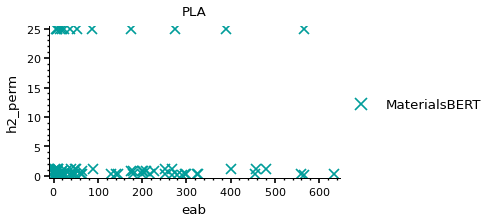

hardness vs. eab


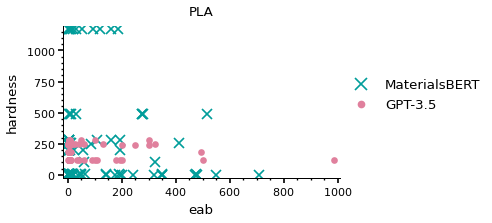

iec vs. eab


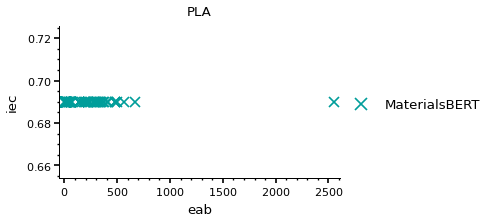

is vs. eab


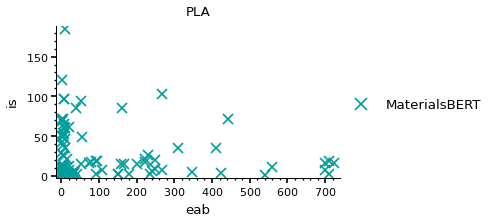

lcst vs. eab


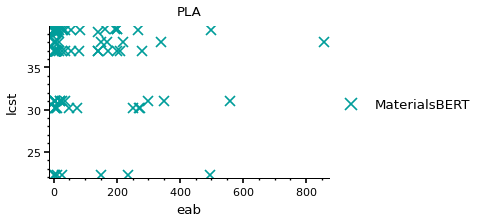

loi vs. eab


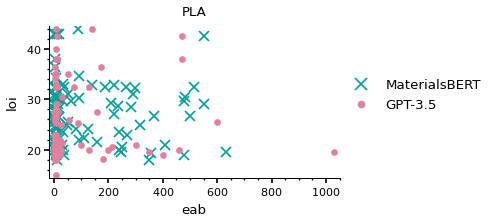

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meoh_perm vs. eab


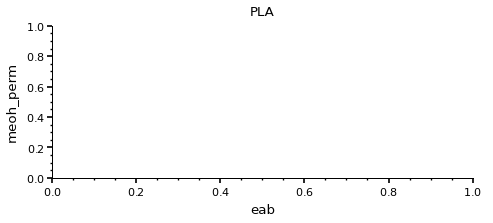

o2_perm vs. eab


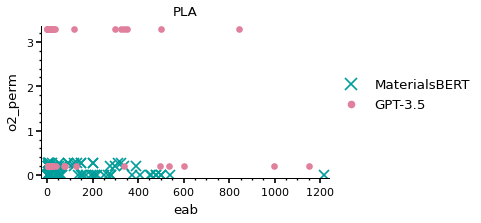

ri vs. eab


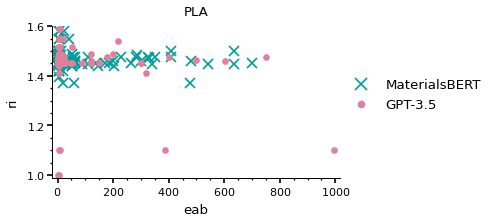

sd vs. eab


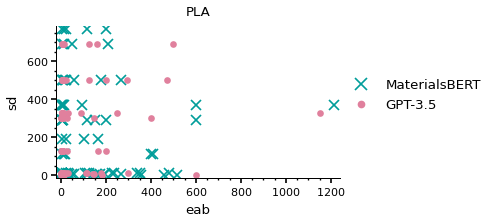

tc vs. eab


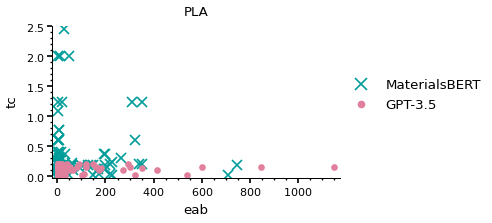

td vs. eab


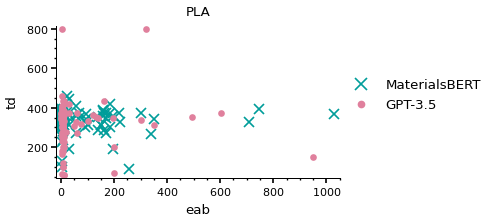

tg vs. eab


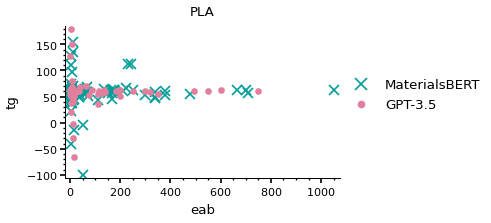

tm vs. eab


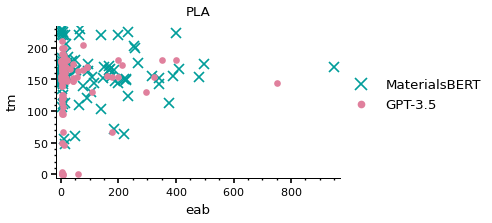

ts vs. eab


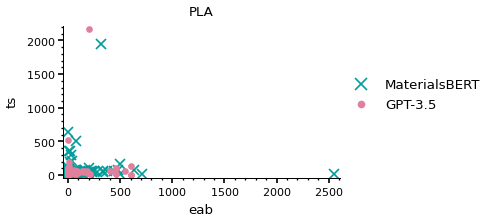

ucst vs. eab


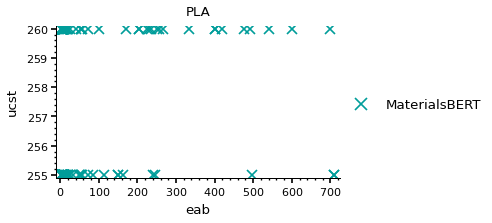

wca vs. eab


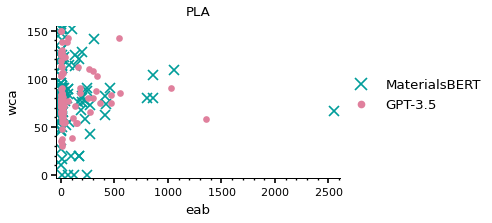

wu vs. eab


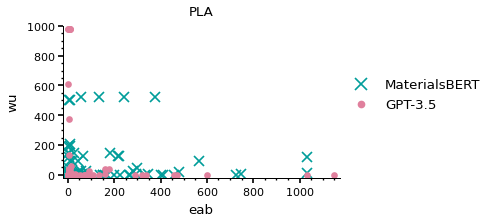

ym vs. eab


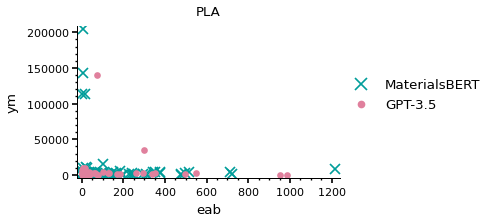

bandgap vs. fs


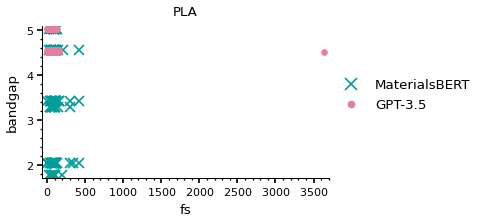

co2_perm vs. fs


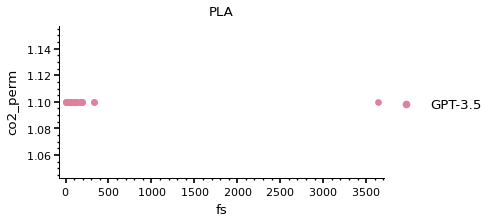

cs vs. fs


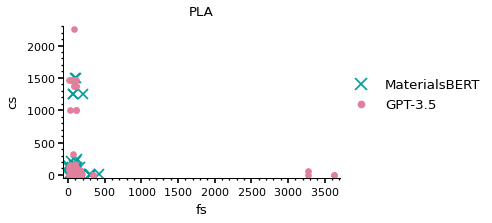

ct vs. fs


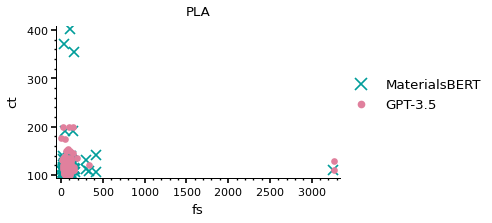

eab vs. fs


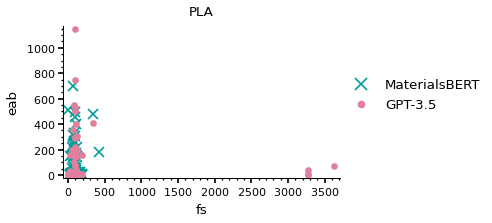

h2_perm vs. fs


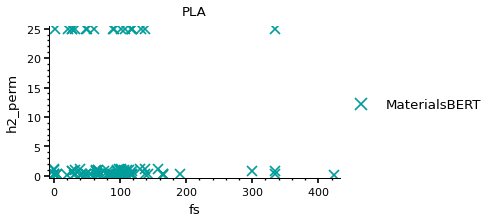

hardness vs. fs


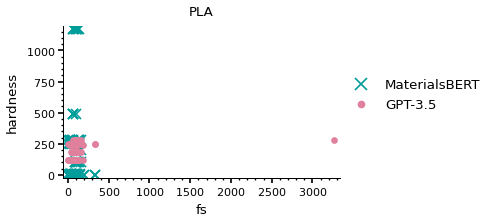

iec vs. fs


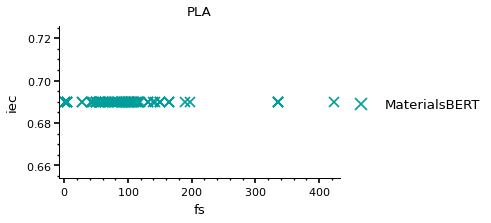

is vs. fs


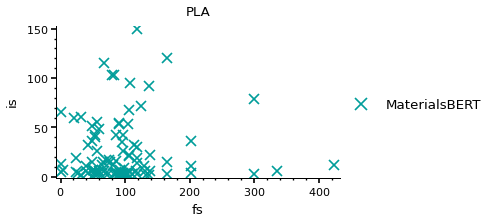

lcst vs. fs


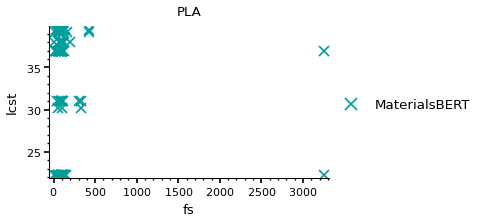

loi vs. fs


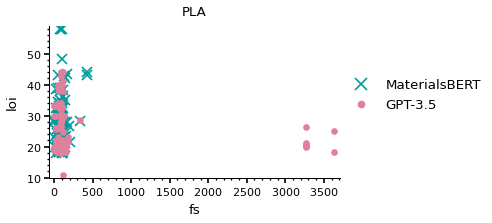

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meoh_perm vs. fs


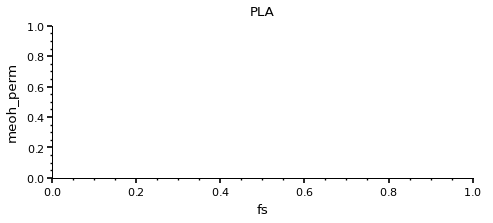

o2_perm vs. fs


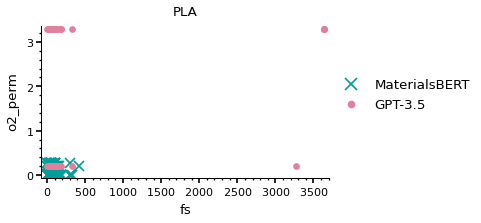

ri vs. fs


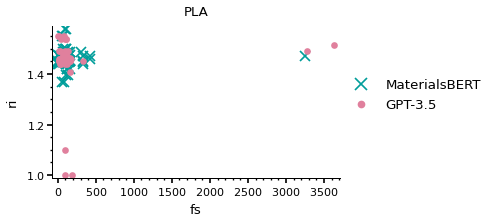

sd vs. fs


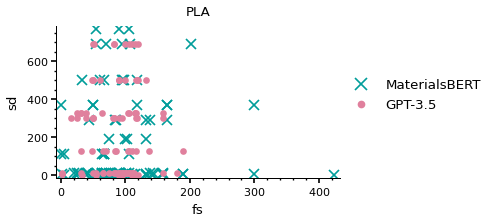

tc vs. fs


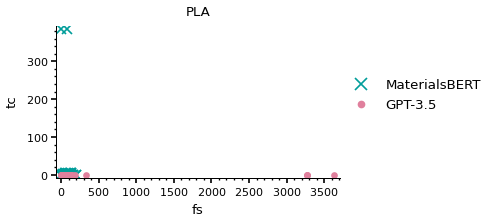

td vs. fs


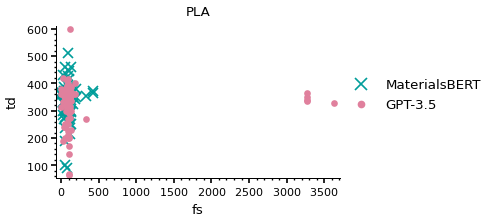

tg vs. fs


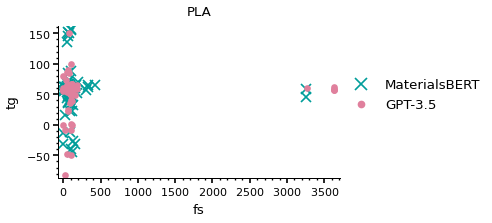

tm vs. fs


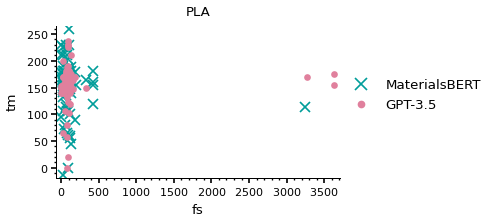

ts vs. fs


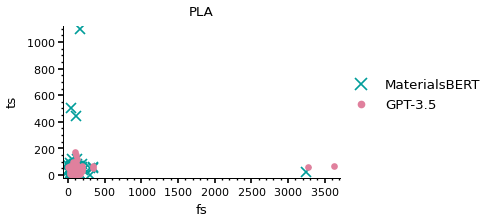

ucst vs. fs


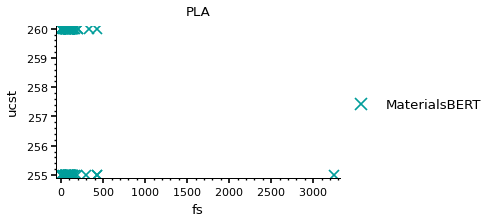

wca vs. fs


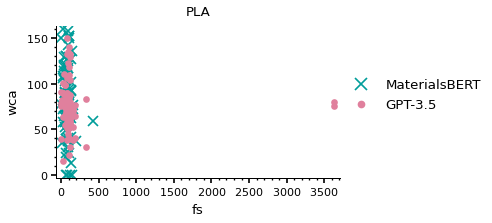

wu vs. fs


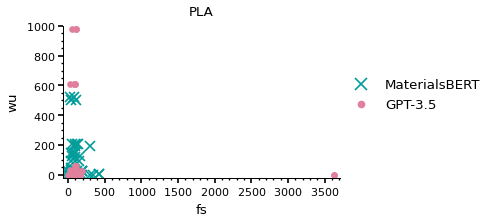

ym vs. fs


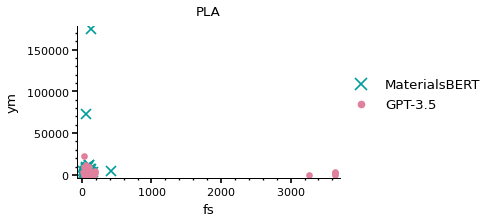

bandgap vs. h2_perm


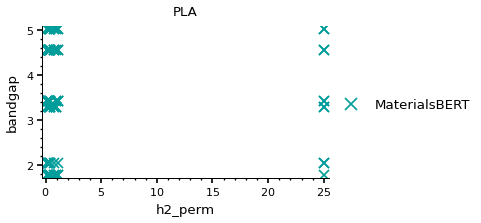

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


co2_perm vs. h2_perm


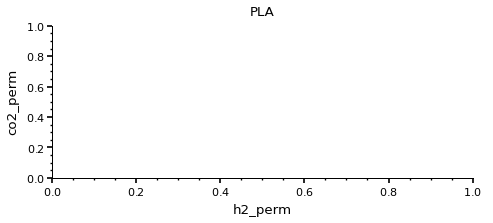

cs vs. h2_perm


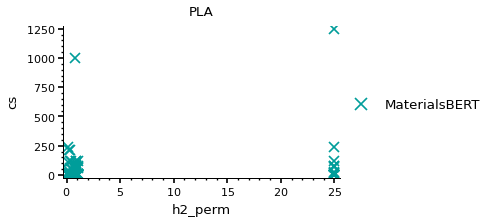

ct vs. h2_perm


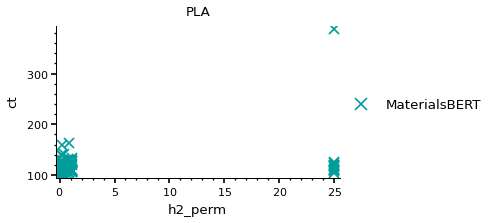

eab vs. h2_perm


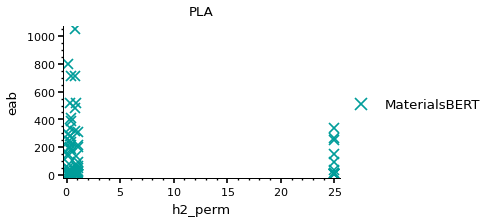

fs vs. h2_perm


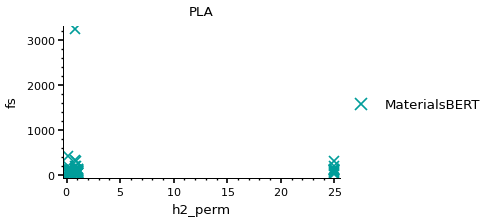

hardness vs. h2_perm


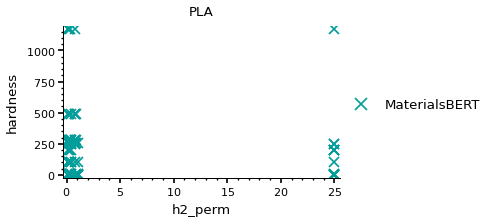

iec vs. h2_perm


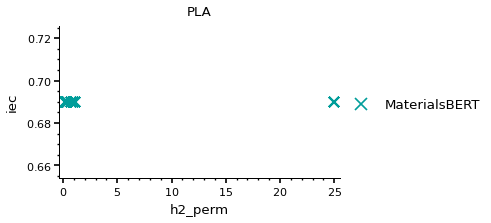

is vs. h2_perm


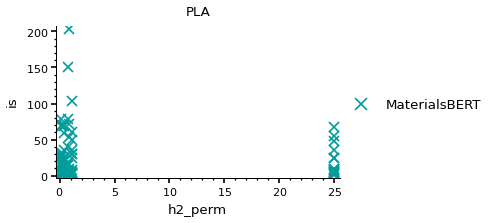

lcst vs. h2_perm


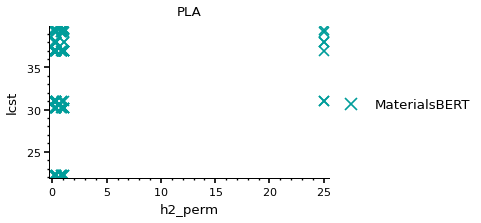

loi vs. h2_perm


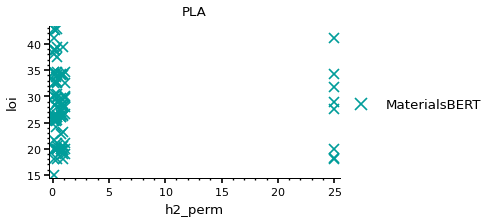

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meoh_perm vs. h2_perm


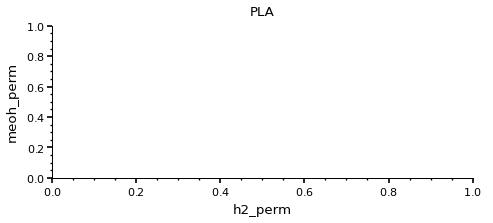

o2_perm vs. h2_perm


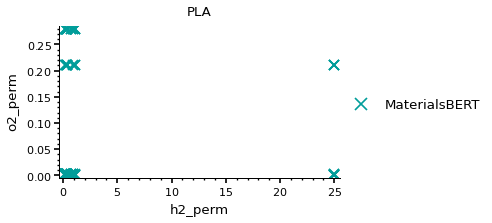

ri vs. h2_perm


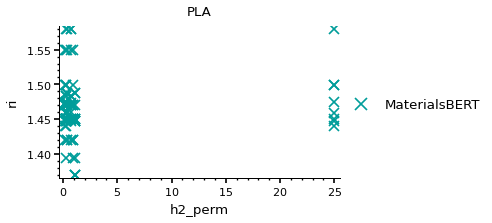

sd vs. h2_perm


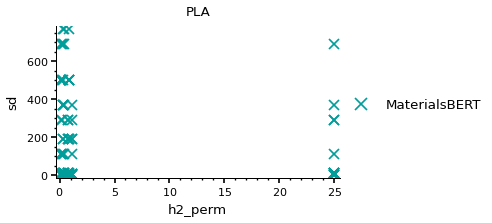

tc vs. h2_perm


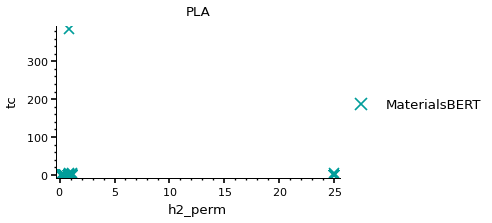

td vs. h2_perm


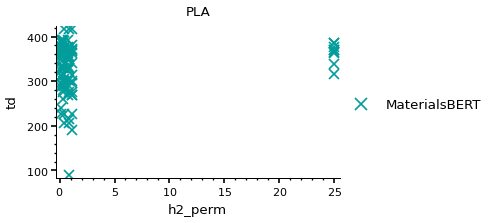

tg vs. h2_perm


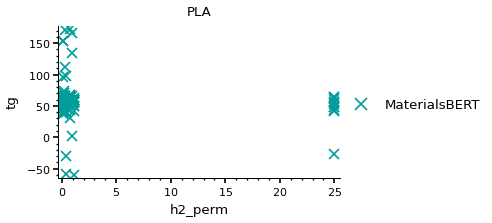

tm vs. h2_perm


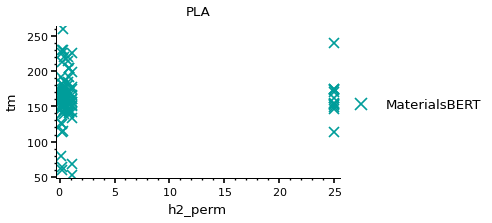

ts vs. h2_perm


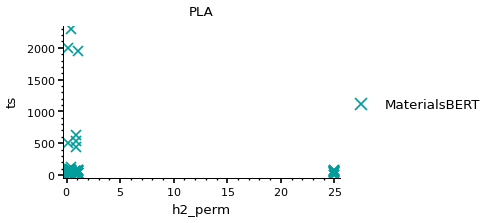

ucst vs. h2_perm


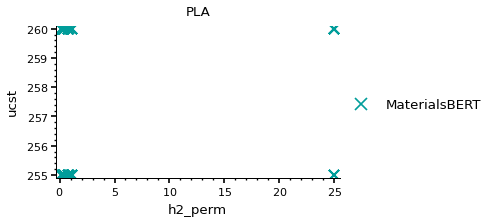

wca vs. h2_perm


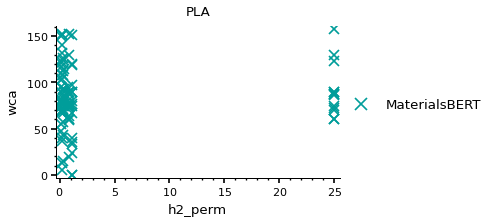

wu vs. h2_perm


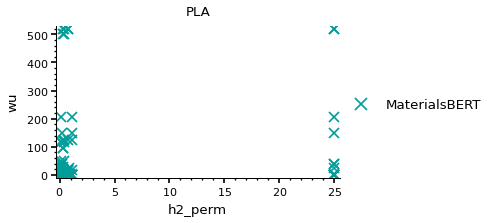

ym vs. h2_perm


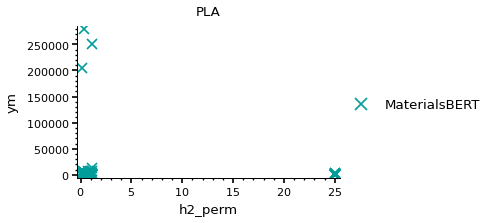

bandgap vs. hardness


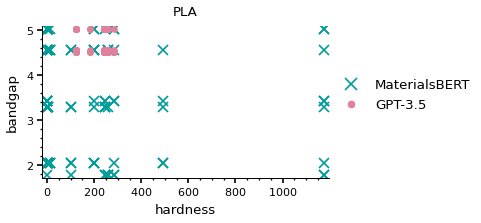

co2_perm vs. hardness


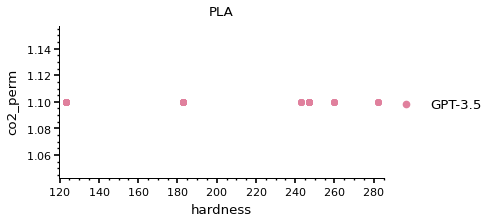

cs vs. hardness


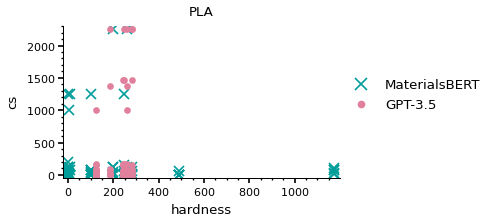

ct vs. hardness


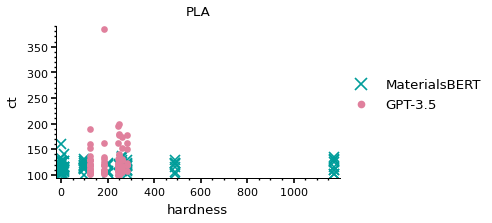

eab vs. hardness


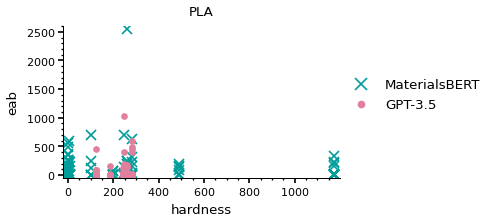

fs vs. hardness


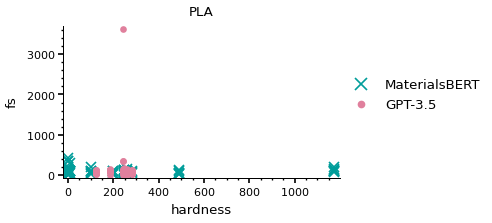

h2_perm vs. hardness


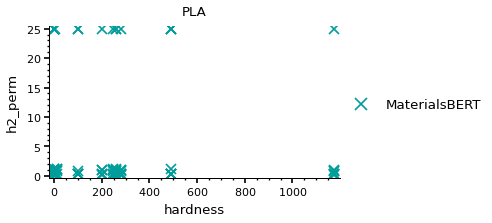

iec vs. hardness


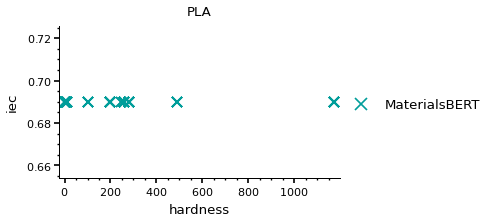

is vs. hardness


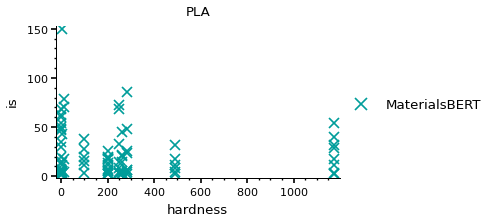

lcst vs. hardness


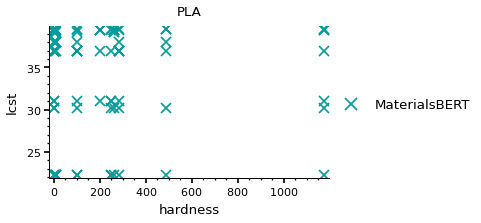

loi vs. hardness


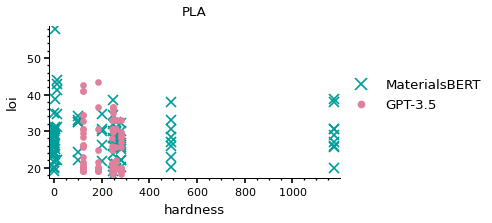

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


meoh_perm vs. hardness


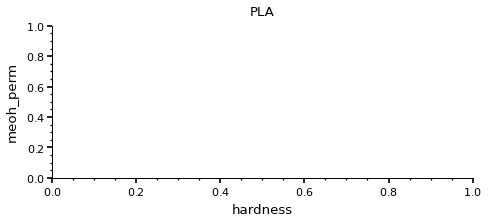

o2_perm vs. hardness


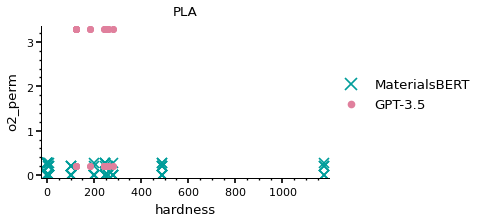

ri vs. hardness


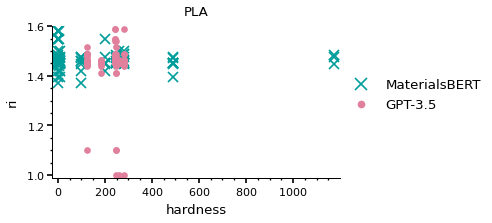

sd vs. hardness


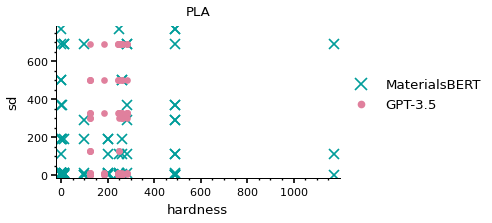

tc vs. hardness


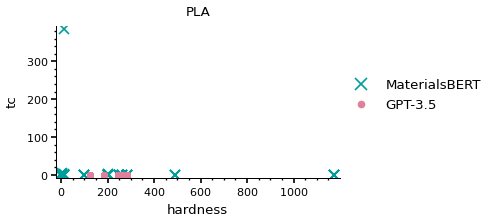

td vs. hardness


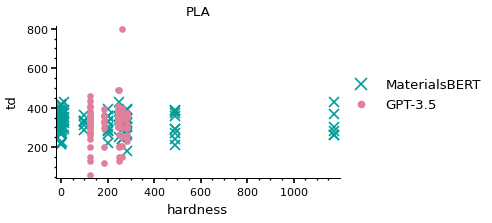

tg vs. hardness


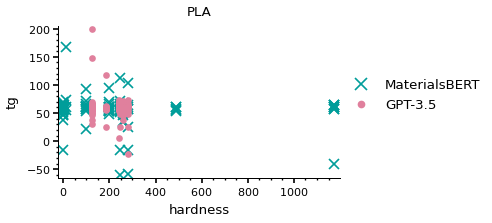

tm vs. hardness


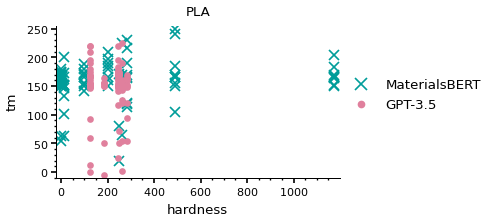

ts vs. hardness


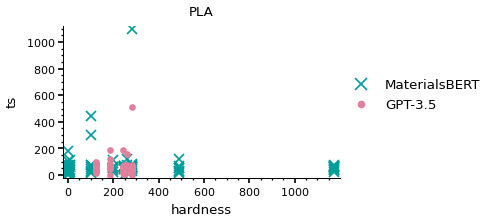

ucst vs. hardness


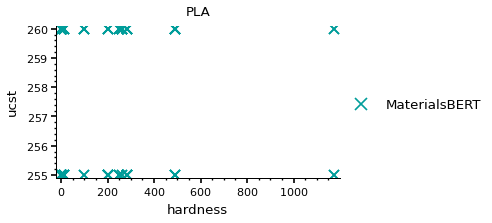

wca vs. hardness


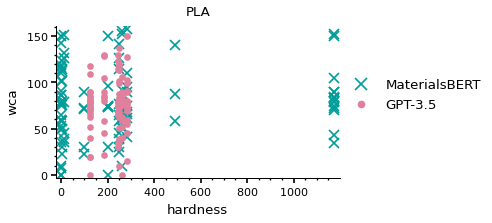

wu vs. hardness


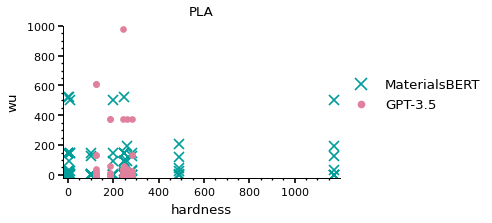

ym vs. hardness


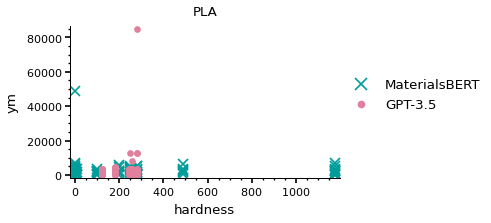

bandgap vs. iec


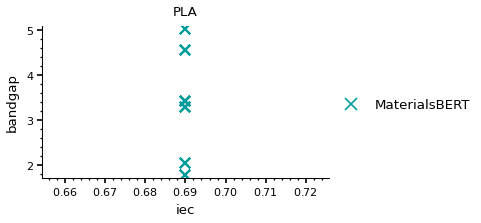

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


co2_perm vs. iec


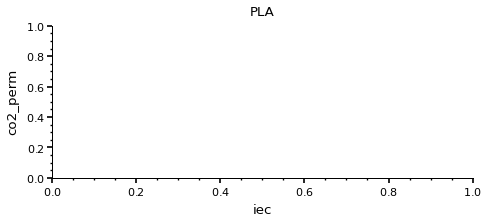

cs vs. iec


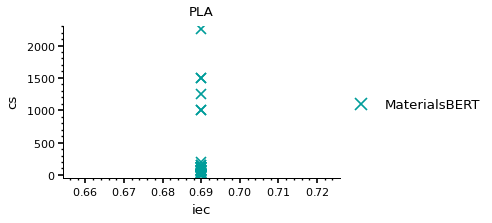

ct vs. iec


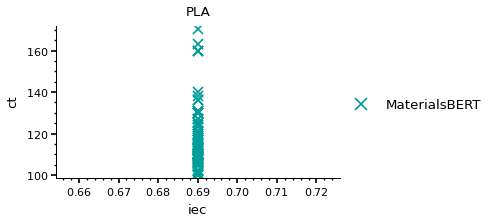

eab vs. iec


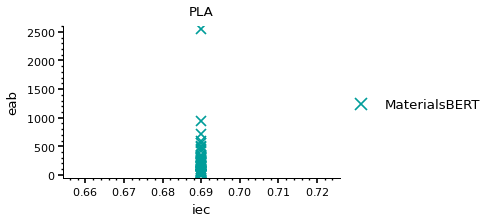

fs vs. iec


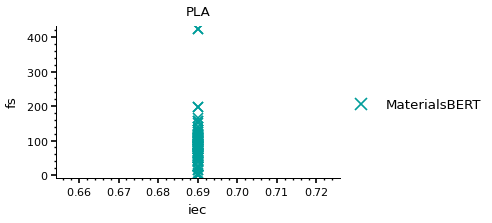

h2_perm vs. iec


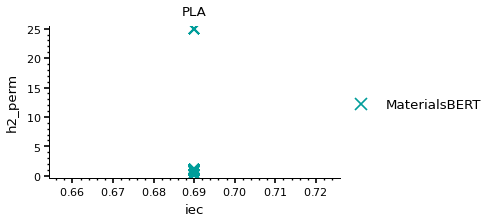

hardness vs. iec


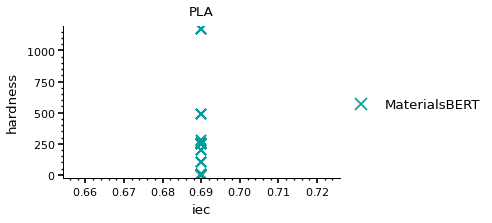

is vs. iec


KeyboardInterrupt: 

In [113]:
props = postgres.raw_sql("SELECT DISTINCT property FROM extracted_data ed;")
props = [p.property for p in props]

for prop1 in props:
    for prop2 in props:
        if prop1 == prop2:
            continue

        print(prop2, 'vs.', prop1)
        plot_jitter_pair(material, prop1, prop2, n)

